Всего ритейлеров: 2737
Общее количество магазинов: 463,118
Среднее число регионов присутствия: 14.89
store_category
Малые            726
Очень крупные    683
Средние          671
Крупные          657
Name: count, dtype: int64


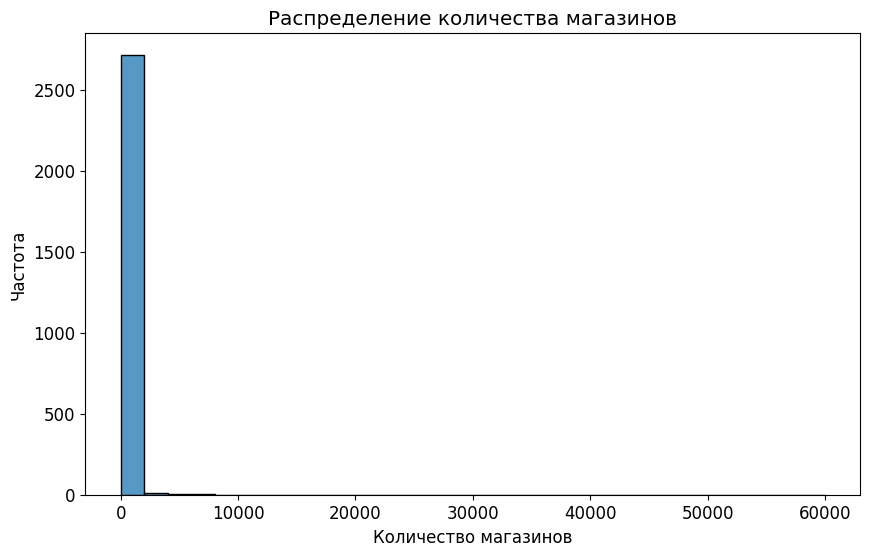

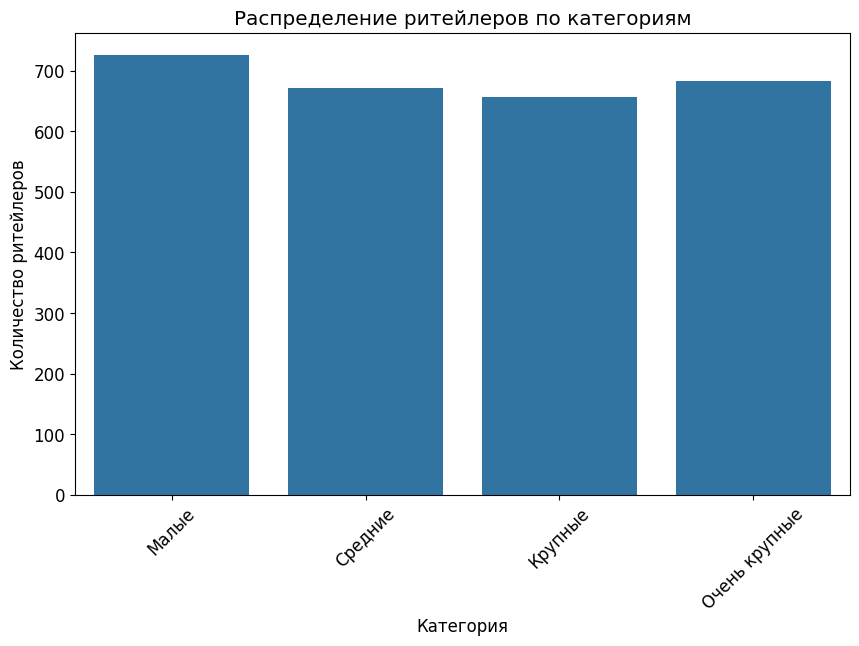

                           Количество сетей  Среднее число магазинов  \
domain                                                                 
Одежда                                  387                    64.13   
Кафе, ресторан                          343                    56.85   
Продукты питания                        274                   162.11   
Товары и услуги для детей               128                    46.29   
Все для дома                            106                    68.55   

                           Всего магазинов  Среднее число регионов  
domain                                                              
Одежда                               24820                   15.76  
Кафе, ресторан                       19500                    8.93  
Продукты питания                     44417                    9.15  
Товары и услуги для детей             5925                   15.49  
Все для дома                          7266                   14.87  


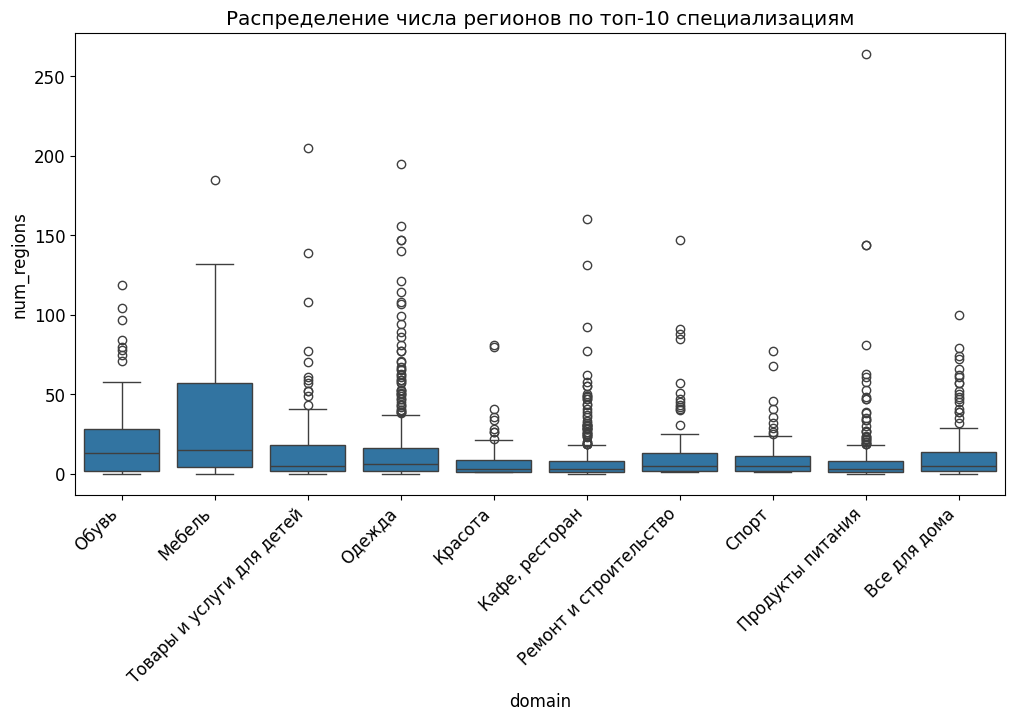

store_category
Малые              inf
Средние          0.372
Крупные          0.327
Очень крупные    0.219
Name: expansion_ratio, dtype: float64


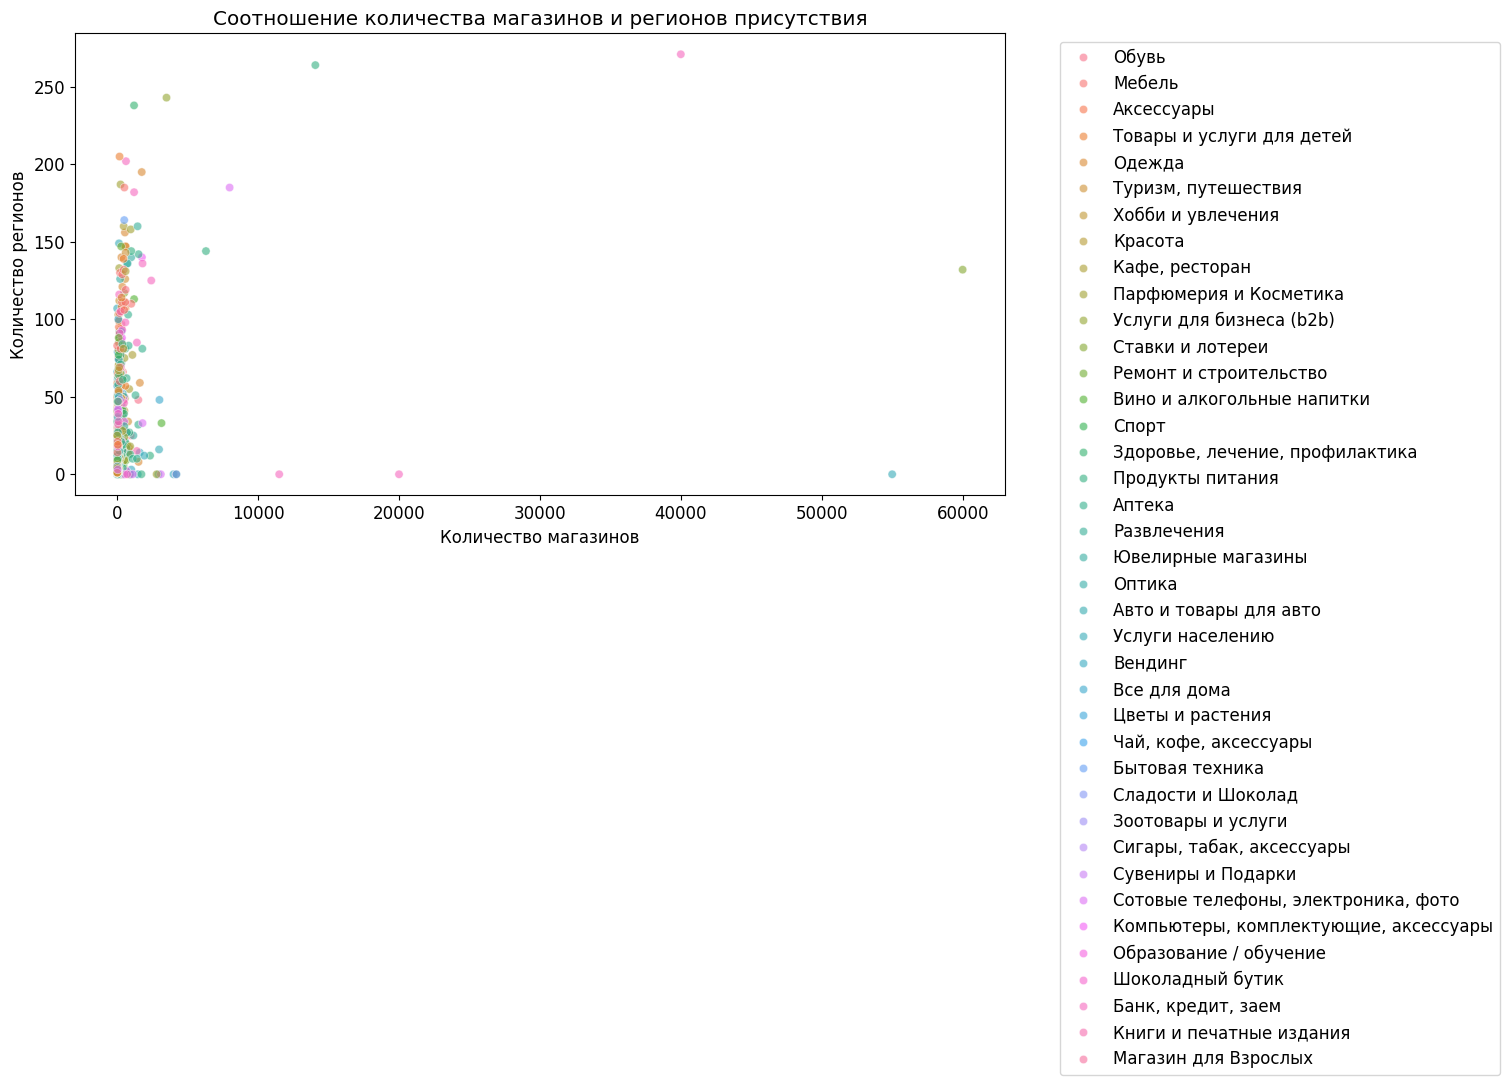

                    count    sum  avg_size  market_share
domain                                                  
Банк, кредит, заем     74  87528   1182.81         18.90
Услуги населению       78  69344    889.03         14.97
Ставки и лотереи        3  60900  20300.00         13.15
Продукты питания      274  44417    162.11          9.59
Одежда                387  24820     64.13          5.36


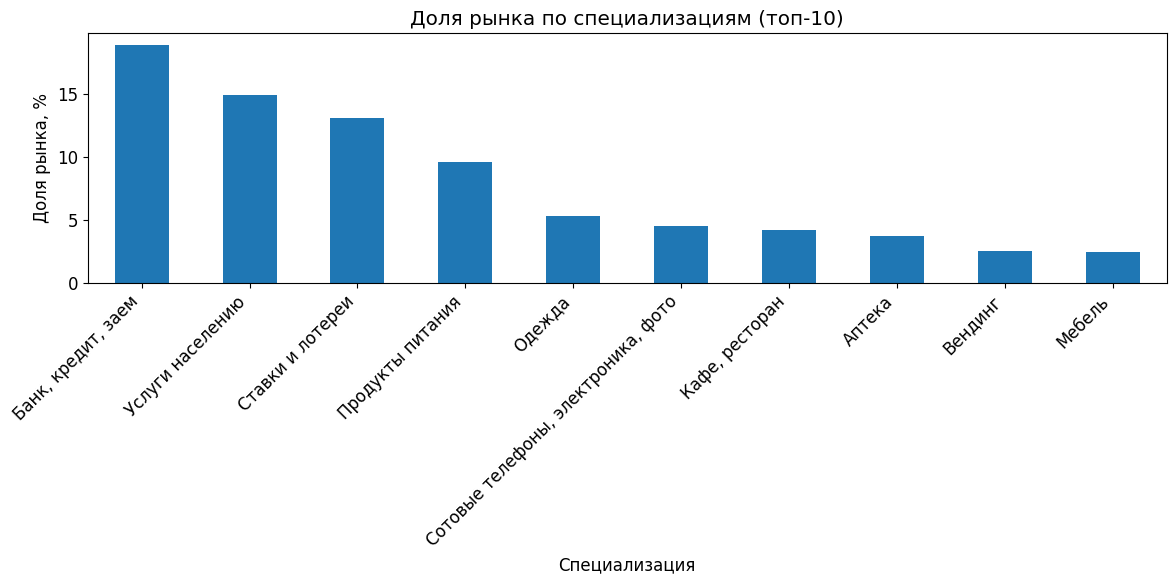


Корреляция между  количеством магазинов и регионов: 0.22


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

class RetailAnalysis:
    def __init__(self, file_path: str):
        self.df = self.load_and_preprocess_data(file_path)
        
    def load_and_preprocess_data(self, file_path: str) -> pd.DataFrame:
        df = pd.read_csv(file_path)
        
        df['total_stores'] = df['presence_russia'].apply(self._extract_store_numbers)
        
        df['num_regions'] = df['presence_regions'].fillna('').apply(
            lambda x: len(x.split(';')) if x else 0
        )
        
        df['store_category'] = pd.qcut(df['total_stores'], 
                                     q=4, 
                                     labels=['Малые', 'Средние', 'Крупные', 'Очень крупные'])
        
        return df
    
    def _extract_store_numbers(self, value: str) -> int:
        if pd.isna(value):
            return 0
        try:
            parts = str(value).split('и')
            total = 0
            for part in parts:
                numbers = ''.join(filter(str.isdigit, part))
                if numbers:
                    total += int(numbers)
            return total
        except:
            return 0
    
    def task1_general_statistics(self):
        print(f"Всего ритейлеров: {len(self.df)}")
        print(f"Общее количество магазинов: {self.df['total_stores'].sum():,}")
        print(f"Среднее число регионов присутствия: {self.df['num_regions'].mean():.2f}")
        print(self.df['store_category'].value_counts())
        
        plt.figure(figsize=(10, 6))
        sns.histplot(data=self.df, x='total_stores', bins=30)
        plt.title('Распределение количества магазинов')
        plt.xlabel('Количество магазинов')
        plt.ylabel('Частота')
        plt.show()
        
        plt.figure(figsize=(10, 6))
        sns.countplot(data=self.df, x='store_category')
        plt.title('Распределение ритейлеров по категориям')
        plt.xlabel('Категория')
        plt.ylabel('Количество ритейлеров')
        plt.xticks(rotation=45)
        plt.show()
        
    def task2_domain_analysis(self):
        domain_stats = self.df.groupby('domain').agg({
            'total_stores': ['count', 'mean', 'sum'],
            'num_regions': 'mean'
        }).round(2)
        
        domain_stats.columns = ['Количество сетей', 'Среднее число магазинов', 
                              'Всего магазинов', 'Среднее число регионов']
        print(domain_stats.sort_values('Количество сетей', ascending=False).head())
        
        plt.figure(figsize=(12, 6))
        top_domains = domain_stats.nlargest(10, 'Количество сетей').index
        sns.boxplot(data=self.df[self.df['domain'].isin(top_domains)], 
                   x='domain', y='num_regions')
        plt.xticks(rotation=45, ha='right')
        plt.title('Распределение числа регионов по топ-10 специализациям')
        plt.show()
        
    def task3_expansion_analysis(self):
        self.df['expansion_ratio'] = self.df['num_regions'] / self.df['total_stores']
        
        print(self.df.groupby('store_category')['expansion_ratio'].mean().round(3))
        
        plt.figure(figsize=(12, 6))
        sns.scatterplot(data=self.df, x='total_stores', y='num_regions', 
                       hue='domain', alpha=0.6)
        plt.title('Соотношение количества магазинов и регионов присутствия')
        plt.xlabel('Количество магазинов')
        plt.ylabel('Количество регионов')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
    def task4_custom_analysis(self):
        market_concentration = (
            self.df.groupby('domain')['total_stores']
            .agg(['count', 'sum'])
            .assign(avg_size=lambda x: x['sum'] / x['count'])
            .assign(market_share=lambda x: x['sum'] / x['sum'].sum() * 100)
            .sort_values('market_share', ascending=False)
            .round(2)
        )
        
        print(market_concentration.head())
        
        plt.figure(figsize=(12, 6))
        market_concentration.head(10)['market_share'].plot(kind='bar')
        plt.title('Доля рынка по специализациям (топ-10)')
        plt.xlabel('Специализация')
        plt.ylabel('Доля рынка, %')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        correlation = self.df['total_stores'].corr(self.df['num_regions'])
        print(f"\nКорреляция между  количеством магазинов и регионов: {correlation:.2f}")

def main():
    analysis = RetailAnalysis('https://raw.githubusercontent.com/zalig/cu-datasets/main/expansion.csv')
    
    analysis.task1_general_statistics() 
    analysis.task2_domain_analysis()
    analysis.task3_expansion_analysis()
    analysis.task4_custom_analysis()

if __name__ == "__main__":
    main()

# Presentation
https://docs.google.com/presentation/d/1OYpWLWLytBremigycI-q825NK_25uuxz5Qzm8jncWvE/edit?usp=sharing